In [1]:
import numpy as np
import tensorflow as tf
import os
import random
import skimage.io
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt

# <strong>Main</strong>


## Data 
The data is converted into RGB tensors with skimage.io.imread()

<strong>Notice:</strong> pip install scikit-image 

### Load

In [2]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        # label_dir contains 61 catefories paths
        label_dir = os.path.join(data_dir, d)

        # list subdirectories within each of the 61 categories
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

# Load training and testing datasets.
ROOT_PATH = "D:\Programming Files\Python Files\Deep learning - traffic signs\Belgium"
train_data_dir = os.path.join(ROOT_PATH, "BelgiumTSC_Training\Training")
test_data_dir = os.path.join(ROOT_PATH, "BelgiumTSC_Testing\Testing")

train_images, train_labels = load_data(train_data_dir)

# Determine image's resolutions 
height = []
width = []
for train_image in train_images:
    height.append((tf.shape(train_image))[0])
    width.append((tf.shape(train_image))[1])
print("Max height:", min(height))


Max height: tf.Tensor(22, shape=(), dtype=int32)


### Display all images


In [5]:
def display_images(images, labels, category=False):
    """
    Display the first image of each label.
    
    Set oneCategory=True when images within a category will be displayed
    """

    if category:
        i = 1
        startIndex = labels.index(category)
        catImages = images[startIndex:(startIndex + labels.count(category))]
        
        plt.figure(figsize=(15, 15))
        for catImage in catImages[:24]:
            plt.subplot(8, 8, i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(catImage)
            i += 1
    
    else:
        unique_labels = set(labels) # Create a list contains only the labels (non-iterative)
    
        #Example: a = [1, 1, 1, 2, 2, 3]
        #set(a) >> {1,2,3}

        plt.figure(figsize=(15, 15))
        i = 1
        for label in unique_labels:
            image = images[labels.index(label)] # Pick the first image for each label.

        # object.index(element) returns the index of the element specified when it first encounters
        # Example: a = [1, 1, 1, 3, 2, 2, 3]
        # a.index(3) = 3

            plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
            plt.xticks([])
            plt.yticks([])
            plt.title("Label {0} ({1})".format(label, labels.count(label))) # sign category and the # of its samples
            plt.imshow(image)
            i += 1
    plt.show()

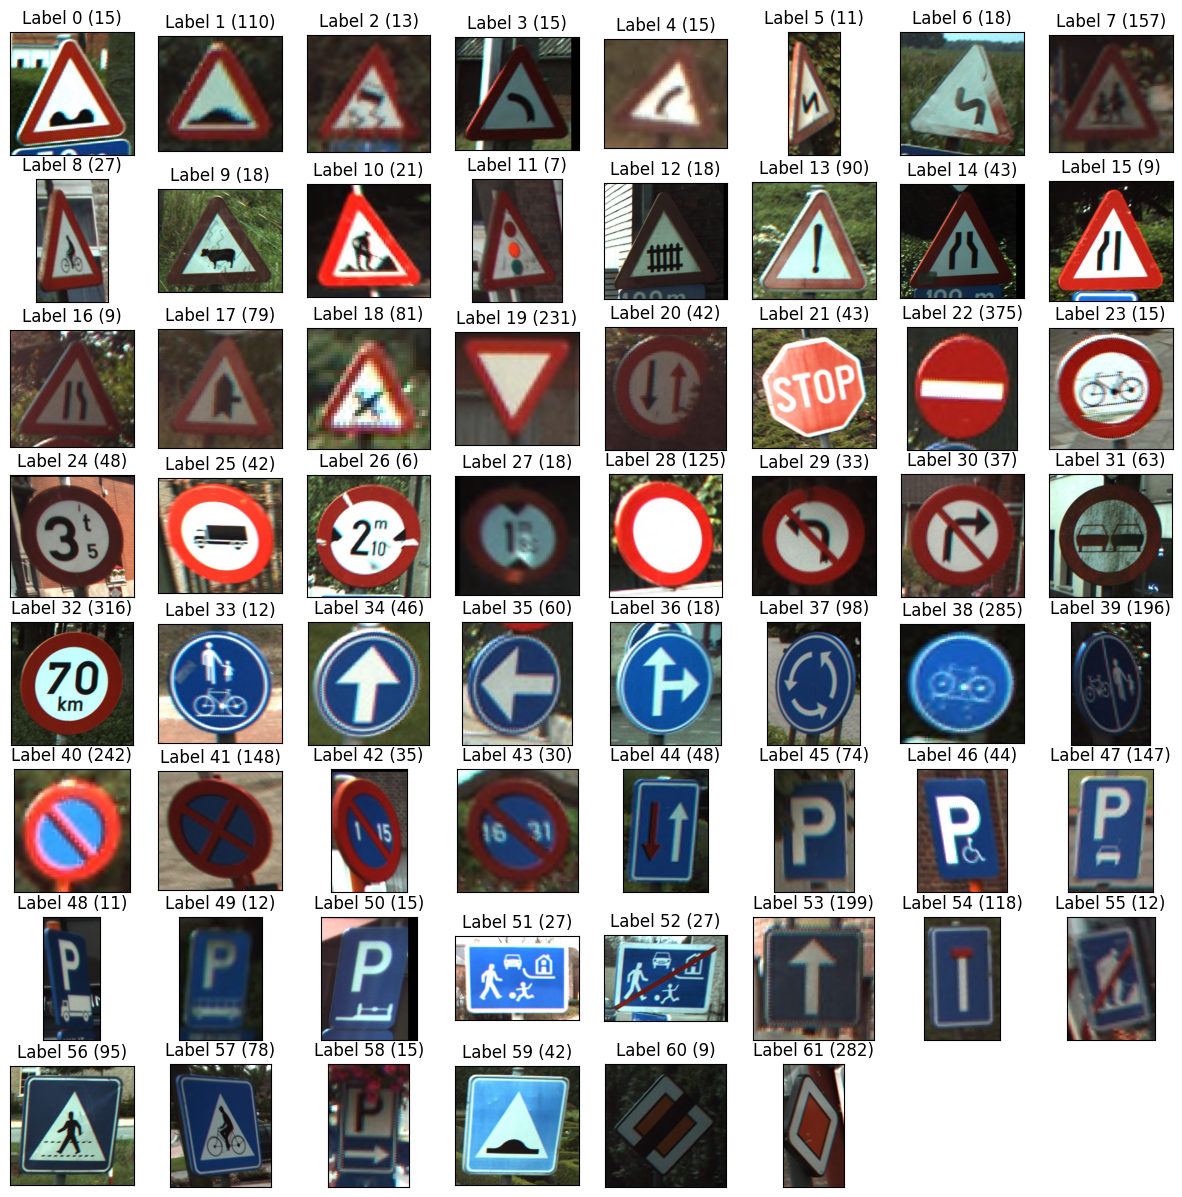

In [26]:
# Display all images 
display_images(train_images, train_labels)

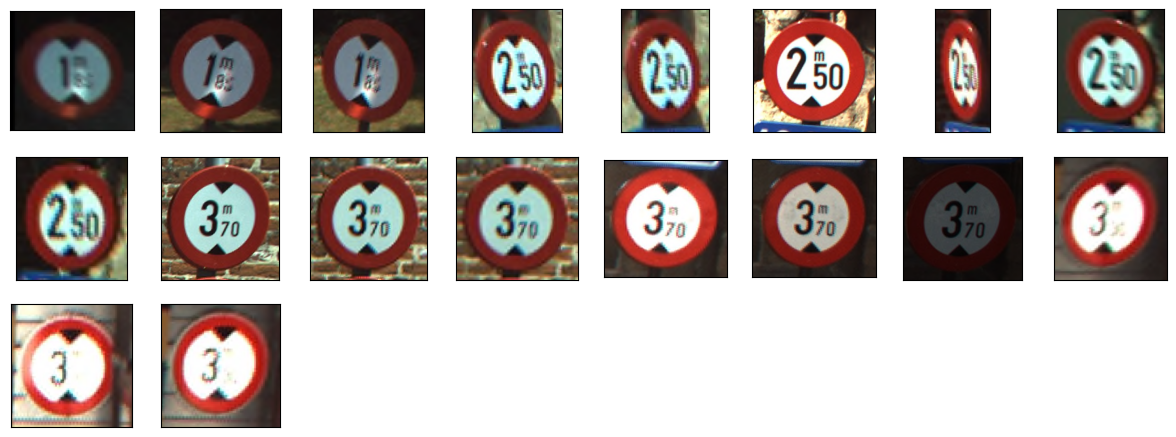

In [30]:
# Display images by category
display_images(train_images, train_labels, category=27)

### Resize

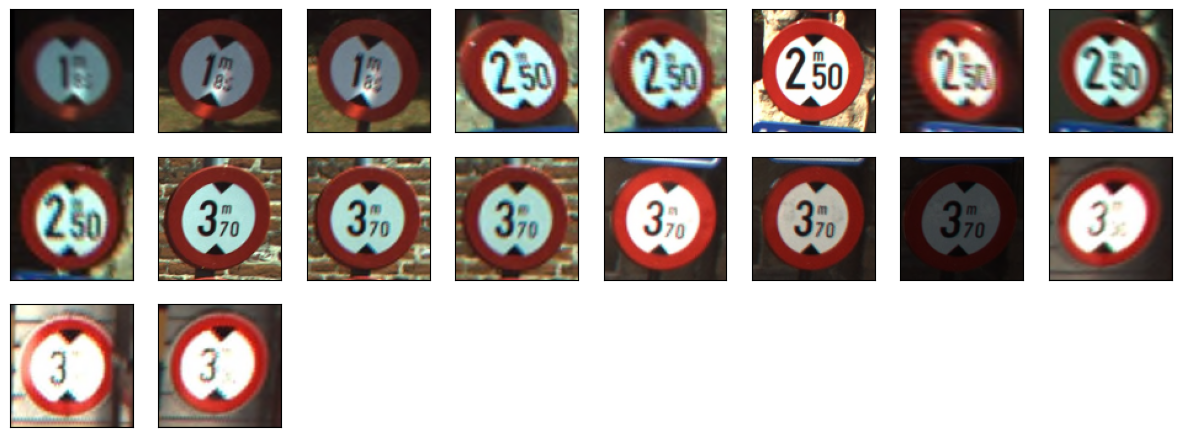

In [10]:
resizedTrainingImages = [ skimage.transform.resize(train_image,(32, 32), mode = "constant") 
                            for train_image in train_images ]
display_images(resizedTrainingImages, train_labels, category=27)

## Model


# <strong>Miscellaneous</strong>

## Layer example

In [3]:
# for one layer
class MyDenseLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(MyDenseLayer, self).__init__() # inherits tf.leras.layers.Layer attributes and behaviors  

        #Initialize weights and biases
        self.W = self.add_weight([input_dim, output_dim])
        self.b = self.add_weight([1, output_dim])

        def call(self, inputs):
            z = tf.matmul(inputs, self.W) + self.b
            outputs = tf.math.sigmoid(z)
            return outputs

## Gradient computation

In [29]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x)
print(dy_dx)


tf.Tensor(6.0, shape=(), dtype=float32)


## Super() examples
use super to access the characteristics of other classes
Ex:
super().__init__(mammalName) is equivalent to Class1.__init_(mammalName)

### Example 1

In [14]:
class Animal(object):
  def __init__(self, Animal):
    print(Animal, 'is an animal.')

class Mammal(Animal):
  def __init__(self, mammalName):
    print(mammalName, 'is a warm-blooded animal.')
    super().__init__(mammalName)

class NonMarineMammal(Mammal):
  def __init__(self, NonMarineMammal):
    print(NonMarineMammal, "can't swim.")
    super().__init__(NonMarineMammal)
   
class NonWingedMammal(Mammal):
  def __init__(self, NonWingedMammal):
    print(NonWingedMammal, "can't fly.")
    super().__init__(NonWingedMammal)

class Dog(NonMarineMammal, NonWingedMammal):
  def __init__(self):
    print('Dog has 4 legs.')
    super().__init__('Dog')
    
d = Dog()
print(d)
# bat = NonMarineMammal('Bat')

Dog has 4 legs.
Dog can't swim.
Dog can't fly.
Dog is a warm-blooded animal.
Dog is an animal.


### Example 2

In [25]:
class Rectangle(object):
    def __init__(self, length, width):
        self.length = length
        self.width = width

    def area(self):
        return self.length * self.length

    def perimeter(self):
        return 2 * self.length + 2 * self.width

# Here we declare that the Square class inherits from the Rectangle class
class Square(Rectangle):
    def __init__(self, length_sqr):
        super().__init__(length_sqr, length_sqr)   # length_sqr = length and width of class Rectangle
Square(5).area()

25